In [1]:

# Set up notebook
%pprint
import sys
if ('../py' not in sys.path): sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

# load libraries
from FRVRS import nu, fu
from numpy import nan
from pandas import (
    CategoricalDtype, DataFrame, Index, NaT, Series, concat, get_dummies, isna, notnull,
    read_csv, read_excel, read_pickle, to_datetime, to_numeric
)
from re import split, search, sub, MULTILINE
from scipy.stats import f_oneway, ttest_ind, kruskal, norm
import itertools
from os import listdir as listdir, makedirs as makedirs, path as osp, remove as remove, sep as sep, walk as walk
import re
import statsmodels.api as sm

In [3]:

# Get all the Open World JSON Stats into one data frame
logs_path = osp.join(nu.data_folder, 'logs', 'Human_Sim_Metrics_Data_4-12-2024')
directories_list = listdir(logs_path)

In [4]:

json_stats_df = DataFrame([])
for dir_name in directories_list:
    
    # Add the JSONs to the data frame
    folder_path = osp.join(logs_path, dir_name)
    
    # Iterate over the files in the current subdirectory
    for file_name in listdir(folder_path):
        
        # If the file is a JSON file
        if file_name.endswith('.json'):
            
            # Create a data frame from the flattened dictionary
            json_path = osp.join(folder_path, file_name)
            with open(json_path, 'r') as f: file_json = json.load(f)
            row_dict = {
                'json_file_subpath': folder_path,
                'json_file_name': file_name
            }
            flattened_json_dict = nu.get_row_dictionary(file_json, row_dict=row_dict, key_prefix='')
            
            # You've got to clean the Session IDs
            session_uuid, participant_id = dir_name.split('_')
            flattened_json_dict['session_uuid'] = session_uuid
            flattened_json_dict['participant_id'] = int(participant_id)
            df = DataFrame(flattened_json_dict, index=Index([0]))
            
            # Append the data frame for the current subdirectory to the main data frame and break the participant ID loop
            json_stats_df = concat([json_stats_df, df], axis='index')
            
json_stats_df = json_stats_df.reset_index(drop=True)


### Drop boring columns

In [5]:

# Check for proper ingestion (duplicate file ingestion, et al)
assert len(json_stats_df.columns) > 4, "Nothing ingested"
assert json_stats_df.participant_id.nunique() == 26, f"Participant count should be 26, it's {json_stats_df.participant_id.nunique()} instead"
nu.save_data_frames(json_stats_df=json_stats_df, verbose=True)

Saving to /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/json_stats_df.csv


In [6]:

json_stats_df.shape

(51, 3535)

In [7]:

for i in range(14):
    column_name = f'configData_narrative_narrativeSections{i:02d}_teleportPointsToActivate'
    if column_name in json_stats_df:
        mask_series = ~json_stats_df[column_name].isnull()
        print( column_name, sorted(json_stats_df[mask_series][column_name].unique()))

configData_narrative_narrativeSections00_teleportPointsToActivate ['Adept 1', 'Soartech 1']
configData_narrative_narrativeSections01_teleportPointsToActivate ['Adept 1']
configData_narrative_narrativeSections03_teleportPointsToActivate ['Soartech 1']
configData_narrative_narrativeSections04_teleportPointsToActivate ['Soartech 1']
configData_narrative_narrativeSections05_teleportPointsToActivate ['Soartech 2']
configData_narrative_narrativeSections06_teleportPointsToActivate ['Soartech 1', 'Soartech 2']
configData_narrative_narrativeSections07_teleportPointsToActivate ['Adept 1']
configData_narrative_narrativeSections08_teleportPointsToActivate ['Adept 1', 'Soartech 1']
configData_narrative_narrativeSections09_teleportPointsToActivate ['Adept 1', 'Soartech 2']
configData_narrative_narrativeSections10_teleportPointsToActivate ['Soartech 2']
configData_narrative_narrativeSections11_teleportPointsToActivate ['Adept 2', 'Freeform']
configData_narrative_narrativeSections12_teleportPointsToAc

In [65]:

position_mask_series = ~json_stats_df.configData_playerData_startPosition_x.isnull()
position_mask_series &= ~json_stats_df.configData_playerData_startPosition_z.isnull()
prefix_str = 'configData_playerData_startPosition_'
xyz_list = ['x', 'y', 'z']
position_columns = on_columns + [f'{prefix_str}{d}' for d in xyz_list]
assert set(position_columns).issubset(set(json_stats_df.columns)), "You've got the wrong position columns"
prefix_str = 'configData_playerData_startP'
right_df = json_stats_df[position_mask_series][position_columns].rename(
    columns={cn: cn.replace(prefix_str, 'p') for cn in position_columns if cn.startswith(prefix_str)}
)

location_mask_series = ~csv_stats_df.player_location_location.isnull()
location_columns = on_columns + ['player_location_location']
assert set(location_columns).issubset(set(csv_stats_df.columns)), "You've got the wrong location columns"
left_df = csv_stats_df[location_mask_series][location_columns]
for i, d in enumerate(xyz_list):
    left_df[f'location_{d}'] = left_df.player_location_location.map(lambda coord_str: eval(coord_str)[i])
left_df = left_df.drop(columns=['player_location_location'])

In [27]:

def get_action_tick_by_position(csv_stats_df, json_stats_df, participant_id, session_uuid, include_y=False):
    on_columns = ['participant_id', 'session_uuid']
    
    location_columns = on_columns + ['player_location_location']
    assert set(location_columns).issubset(
        set(csv_stats_df.columns)
    ), f"csv_stats_df is missing these columns: {set(location_columns).difference(set(csv_stats_df.columns))}"
    location_mask_series = ~csv_stats_df.player_location_location.isnull()
    assert location_mask_series.any(), f"You don't have any player location data in csv_stats_df"
    location_session_mask = (csv_stats_df.participant_id == participant_id) & (csv_stats_df.session_uuid == session_uuid)
    assert location_session_mask.any(), f"You don't have any CSV data for participant #{participant_id} session #{session_uuid}"
    location_mask_series &= location_session_mask
    assert location_mask_series.any(), f"You don't have any player location data for participant #{participant_id} session #{session_uuid}"
    
    prefix_str = 'configData_playerData_startPosition_'
    if include_y:
        xyz_list = ['x', 'y', 'z']
    else:
        xyz_list = ['x', 'z']
    position_columns = on_columns + [f'{prefix_str}{d}' for d in xyz_list]
    assert set(position_columns).issubset(
        set(json_stats_df.columns)
    ), f"json_stats_df is missing these columns: {set(position_columns).difference(set(json_stats_df.columns))}"
    position_session_mask = (json_stats_df.participant_id == participant_id) & (json_stats_df.session_uuid == session_uuid)
    assert position_session_mask.any(), f"You don't have any JSON data for participant #{participant_id} session #{session_uuid}"
    
    position_mask_series = False
    position_mask_series |= json_stats_df.configData_narrative_narrativeSections11_teleportPointsToActivate.isin(['Freeform'])
    position_mask_series |= json_stats_df.configData_narrative_narrativeSections12_teleportPointsToActivate.isin(['Freeform'])
    position_mask_series |= json_stats_df.configData_narrative_narrativeSections13_teleportPointsToActivate.isin(['Freeform'])
    position_x = json_stats_df[position_mask_series].configData_playerData_startPosition_x.squeeze()
    if include_y:
        position_y = json_stats_df[position_mask_series].configData_playerData_startPosition_y.squeeze()
    position_z = json_stats_df[position_mask_series].configData_playerData_startPosition_z.squeeze()
    if include_y:
        base_point = (position_x, position_y, position_z)
    else:
        base_point = (position_x, position_z)
    
    left_df = csv_stats_df[location_mask_series][location_columns]
    for i, d in enumerate(xyz_list):
        left_df[f'location_{d}'] = left_df.player_location_location.map(lambda coord_str: eval(coord_str)[i])
    left_df = left_df.drop(columns=['player_location_location'])

In [102]:

right_gb = right_df.groupby(on_columns)
left_gb = left_df.groupby(on_columns)
tuples_list = sorted(set(right_gb.groups.keys()).intersection(set(left_gb.groups.keys())))
location_groupby_columns = [f'location_{d}' for d in xyz_list]
rows_list = []
for key_tuple in tuples_list:
    position_mask_series = (right_df.participant_id == key_tuple[0]) & (right_df.session_uuid == key_tuple[1])
    position_x = right_df[position_mask_series].position_x.squeeze()
    position_y = right_df[position_mask_series].position_y.squeeze()
    position_z = right_df[position_mask_series].position_z.squeeze()
    # display(right_df[position_mask_series].drop_duplicates())
    base_point = (position_x, position_y, position_z)
    
    location_mask_series = (left_df.participant_id == key_tuple[0]) & (left_df.session_uuid == key_tuple[1])
    neighbors_list = [(x, y, z) for (x, y, z), _ in left_df[location_mask_series].groupby(location_groupby_columns)]
    nearest_neighbor = nu.get_nearest_neighbor(base_point, neighbors_list)
    euclidean_distance = nu.get_euclidean_distance(base_point, nearest_neighbor)
    row_dict = {
        'base_point': base_point,
        'nearest_neighbor': nearest_neighbor,
        'euclidean_distance': euclidean_distance,
    }
    base_point = (position_x, position_z)
    neighbors_list = [(x, z) for (x, y, z), _ in left_df[location_mask_series].groupby(location_groupby_columns)]
    nearest_neighbor = nu.get_nearest_neighbor(base_point, neighbors_list)
    euclidean_distance = nu.get_euclidean_distance(base_point, nearest_neighbor)
    row_dict['euclidean_distance_xz'] = euclidean_distance
    rows_list.append(row_dict)
euclidean_distance_df = DataFrame(rows_list)

In [29]:

# load data frames
data_frames_dict = nu.load_data_frames(
    verbose=True, csv_stats_df=''
)
csv_stats_df = data_frames_dict['csv_stats_df'].copy()
print(csv_stats_df.shape)
print(sorted([cn for cn in csv_stats_df.columns if 'partici' in cn]))

No pickle exists for csv_stats_df - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/csv_stats_df.csv.
(199476, 124)
['participant_id']


In [30]:

mask_series = False
mask_series |= json_stats_df.configData_narrative_narrativeSections11_teleportPointsToActivate.isin(['Freeform'])
mask_series |= json_stats_df.configData_narrative_narrativeSections12_teleportPointsToActivate.isin(['Freeform'])
mask_series |= json_stats_df.configData_narrative_narrativeSections13_teleportPointsToActivate.isin(['Freeform'])
columns_list = [
    'configData_narrative_narrativeSections00_sectionDescription', 'configData_playerData_startPosition_x',
    'configData_playerData_startPosition_z'
]
for (participant_id, session_uuid), session_df in json_stats_df[mask_series].groupby(['participant_id', 'session_uuid']):
    display(session_df[columns_list].drop_duplicates())
    print(get_action_tick_by_position(csv_stats_df, json_stats_df, participant_id, session_uuid, include_y=False))
    break

,configData_narrative_narrativeSections00_sectionDescription,configData_playerData_startPosition_x,configData_playerData_startPosition_z
8,Initialization,-21.73,-4.0


None


In [21]:

# [cn for cn in df.columns if 'position' in cn.lower()]
mask_series = (df.configData_narrative_narrativeSections00_sectionDescription == 'Initialization')
# df.configData_scene.unique() == ['sim-urban-sanitized', 'sim-desert', 'sim-jungle']
df = df[mask_series].drop_duplicates()

In [22]:

# Calculate the standard deviation for each column
std_dev = df.std()

# Get the indices of columns with zero variance
zero_variance_cols = std_dev[std_dev == 0].index

# Remove columns with zero variance
column_count = df.shape[1]
df.drop(columns=zero_variance_cols, inplace=True)
print(f"Dropped {int(column_count - df.shape[1])} JSON columns with zero variance")

# Assess the number of unique values (excluding NaNs) in each column
unique_values = df.nunique(dropna=True)

# Isolate the indices of columns with fewer than two unique values
few_unique_cols = unique_values[unique_values < 2].index

# Remove columns with fewer than two unique values
column_count = df.shape[1]
df.drop(columns=few_unique_cols, inplace=True)
print(f"Dropped {int(column_count - df.shape[1])} JSON columns with fewer than two unique values")

Dropped 254 JSON columns with zero variance
Dropped 564 JSON columns with fewer than two unique values


In [ ]:

df

In [39]:

free_regex = re.compile('free', re.IGNORECASE)
free_columns = sorted(nu.get_regexed_columns(json_stats_df, search_regex=free_regex))
if len(free_columns) > 2:
    for column_name in sorted(free_columns):
        print(column_name)
else:
    display(json_stats_df[free_columns].drop_duplicates())

configData_narrative_narrativeSections11_teleportPointsToActivate
configData_narrative_narrativeSections12_teleportPointsToActivate
configData_narrative_narrativeSections13_teleportPointsToActivate
configData_narrative_narrativeSections14_narratorRadioAudio_audioClip
configData_narrative_narrativeSections14_sectionDescription
configData_narrative_narrativeSections14_teleportPointsToActivate
configData_narrative_narrativeSections15_teleportPointsToActivate


In [ ]:

adept_regex = re.compile('adept', re.IGNORECASE)
adept_columns = sorted(nu.get_regexed_columns(json_stats_df, search_regex=adept_regex))
if len(adept_columns) > 2:
    for column_name in sorted(adept_columns):
        print(column_name)
else:
    display(json_stats_df[adept_columns].drop_duplicates())

In [ ]:

soartech_regex = re.compile('soartech', re.IGNORECASE)
soartech_columns = sorted(nu.get_regexed_columns(json_stats_df, search_regex=soartech_regex))
if len(soartech_columns) > 2:
    for column_name in sorted(soartech_columns):
        print(column_name)
else:
    display(json_stats_df[soartech_columns].drop_duplicates())

In [ ]:

for column_name in sorted(set(adept_columns).intersection(set(soartech_columns))):
    print(column_name)

In [ ]:

for i in range(14):
    column_name = f'configData_narrative_narrativeSections{i:02d}_sectionDescription'
    if column_name in json_stats_df:
        mask_series = ~json_stats_df[column_name].isnull()
        print(column_name, sorted(json_stats_df[mask_series][column_name].unique()))

In [ ]:

for column_name in sorted([cn for cn in json_stats_df.columns if any(map(lambda x: x in cn.lower(), ['start', 'intro', 'free', 'form']))]):
    print(column_name)

In [ ]:

for column_name in sorted([cn for cn in json_stats_df.columns if any(map(lambda x: x in cn.lower(), ['position']))]):
    print(column_name)

In [52]:

sorted(fu.location_id_columns_list)

['bag_access_location', 'bag_closed_location', 'injury_record_injury_injury_locator', 'injury_treated_injury_injury_locator', 'patient_demoted_position', 'patient_engaged_position', 'patient_record_position', 'player_gaze_location', 'player_location_location', 's_a_l_t_walk_if_can_sort_location', 's_a_l_t_walked_sort_location', 's_a_l_t_wave_if_can_sort_location', 's_a_l_t_waved_sort_location', 'tag_discarded_location', 'teleport_location', 'tool_discarded_location', 'triage_level_walked_location']

In [50]:

# load data frames
data_frames_dict = nu.load_data_frames(
    verbose=True, metrics_evaluation_open_world_csv_stats_df=''
)
csv_stats_df = data_frames_dict['metrics_evaluation_open_world_csv_stats_df'].copy()

No pickle exists for metrics_evaluation_open_world_csv_stats_df - attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/csv/metrics_evaluation_open_world_csv_stats_df.csv.


In [51]:

location_regex = re.compile(r'\((?:-?\d{1,2}\.\d, ){2}-?\d{1,2}\.\d\)')
location_columns = sorted(nu.get_regexed_columns(csv_stats_df, search_regex=location_regex))
if len(location_columns) > 2:
    for column_name in sorted(location_columns):
        print(column_name)
elif len(location_columns):
    display(json_stats_df[location_columns].drop_duplicates())

bag_access_location
bag_closed_location
injury_record_injury_injury_locator
injury_treated_injury_injury_locator
location_id
patient_demoted_position
patient_engaged_position
patient_record_position
player_gaze_direction_of_gaze
player_gaze_location
player_location_left_hand_location
player_location_location
player_location_right_hand_location
tag_discarded_location
teleport_location
tool_discarded_location
triage_level_walk_if_can_location
triage_level_walked_location
triage_level_wave_if_can_location
triage_level_waved_location


In [53]:

# Columns to merge the JSON stats dataset with the CSV stats on
on_columns = sorted(set(csv_stats_df.columns).intersection(set(json_stats_df.columns)))
print(on_columns)

['participant_id', 'session_uuid']


In [66]:

sorted(right_df.position_y.unique())

[0.0]

In [67]:

sorted(left_df.location_y.unique())

[0.0, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.3, 2.4, 2.5, 2.6, 2.8, 2.9, 3.0, 3.2, 3.3, 3.4, 3.5, 4.5, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]

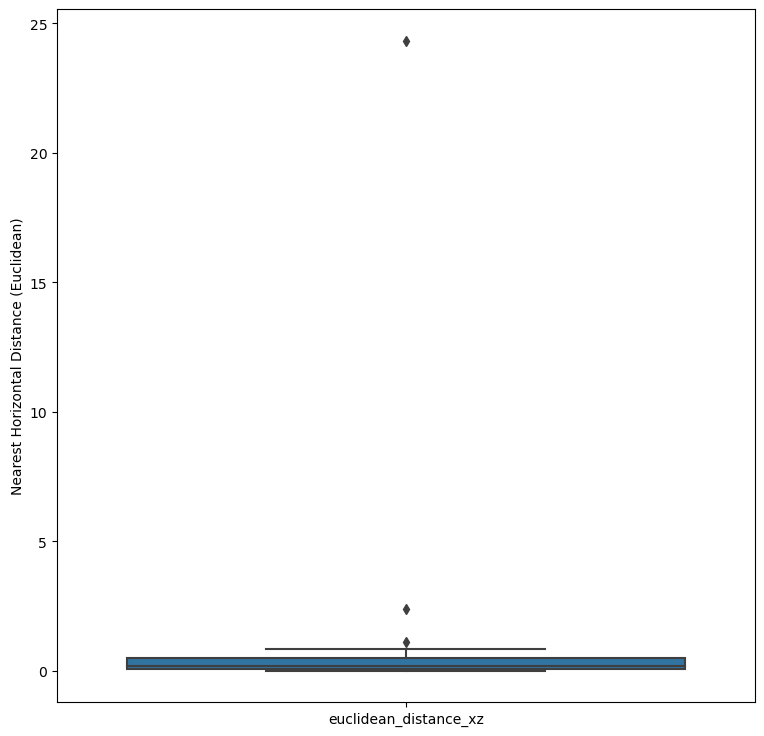

In [103]:

import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Create a box plot of all the columns
columns_list = ['euclidean_distance_xz']
sns.boxplot(euclidean_distance_df[columns_list], ax=ax)

# Label the y-axis
ax.set_ylabel('Nearest Horizontal Distance (Euclidean)')

plt.show()

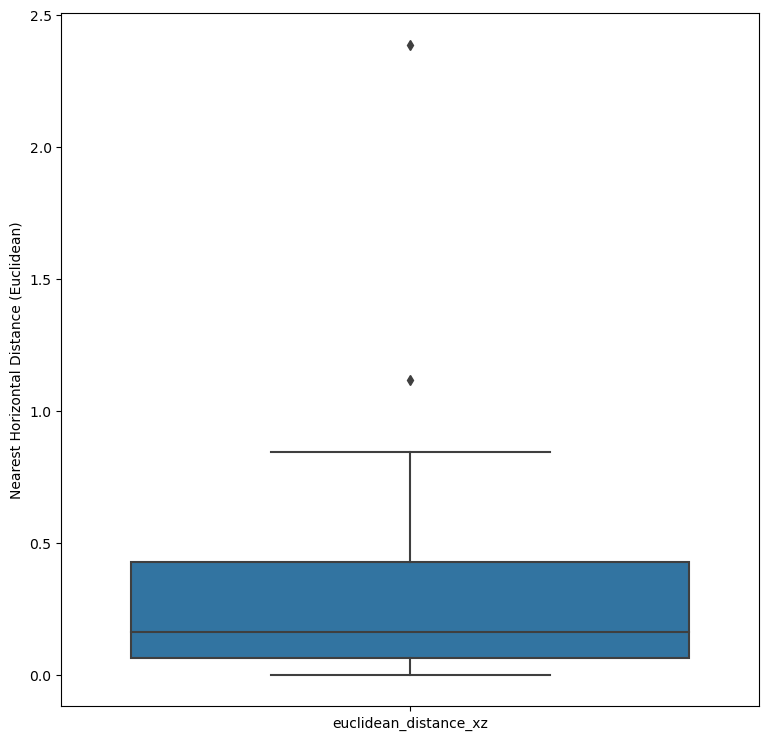

In [104]:

# Create a figure and subplots
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

# Create a box plot of all the columns
mask_series = (euclidean_distance_df.euclidean_distance_xz < 20)
columns_list = ['euclidean_distance_xz']
sns.boxplot(euclidean_distance_df[mask_series][columns_list], ax=ax)

# Label the y-axis
ax.set_ylabel('Nearest Horizontal Distance (Euclidean)')

plt.show()

In [105]:

euclidean_distance_df.sort_values('euclidean_distance_xz', ascending=False).head()

,base_point,nearest_neighbor,euclidean_distance,euclidean_distance_xz
0,"(-21.729999542236328, 0.0, -4.0)","(2.0, 1.7, 1.4)",24.395960,24.336657
6,"(-0.23199999332427979, 0.0, -0.05299999937415123)","(1.8, 1.7, 1.2)",2.930705,2.387265
43,"(0.0, 0.0, 0.0)","(0.2, 1.5, 1.1)",1.870829,1.118034
22,"(-21.729999542236328, 0.0, -4.0)","(-22.2, 1.4, -3.3)",1.634289,0.843149
34,"(-0.23199999332427979, 0.0, -0.05299999937415123)","(0.7, 1.5, -0.1)",1.766588,0.772550
